In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

import yaml
from joblib import dump

import functions    # local functions in this repository

In [2]:
with open("config.ini", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

clm = cfg['column names database']

load data

In [3]:
transactions = pd.read_csv(cfg['CSV filenames']['database'] + '.csv', encoding = "ISO-8859-1", 
    parse_dates=[clm['date']], date_format=cfg['date format'])

split train & test data

In [5]:
transactions_train, transactions_test = train_test_split(
    transactions, test_size=0.2, stratify=transactions[clm['category']],
    random_state=42)

y_train = transactions_train[clm['category']]

pre-processing & model pipeline

In [6]:
textpreprocessing = make_pipeline(
    functions.CleanTexts(threshold = 90, max_edits = 3) ,
    CountVectorizer(
        token_pattern=r"(?u)\b\w{4,}\b" ,    # min word length
        ngram_range=(1,3) ,                  # number of consecutive words
        min_df = 1 ,                         # min word frequency
        binary=True ,                        # vector output: occurrence only or word counts
        )
)

preprocessing = make_column_transformer(
    (textpreprocessing, clm['text']) ,
    (functions.CyclicalEncoder(periods=[31,12]), ["day","month"]) ,
    ('passthrough', [clm['amount']]) ,
)

classifier = make_pipeline(
    functions.DayMonth(clm['date'], cfg['date format']) ,
    preprocessing , 
    ExtraTreesClassifier(n_estimators = 130, min_samples_split = 10, n_jobs=-1)  # hyperparameters optimized
)

classifier.fit(transactions_train, y_train)

Pipeline(steps=[('daymonth', DayMonth(col='Datum', format='%d.%m.%Y')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('cleantexts',
                                                                   CleanTexts(max_edits=3,
                                                                              threshold=90)),
                                                                  ('countvectorizer',
                                                                   CountVectorizer(binary=True,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   token_pattern='(?u)\\b\\w{4,}\\b'))]),
                                                  'Buchungstext'),
                                                 ('cyclicalencoder',
                                                  CyclicalEncoder(periods=[31,
                                                                           12]),
                                                  ['day', 'month']),
                                                 ('passthrough', 'passthrough',
                                                  ['Betrag'])])),
                ('extratreesclassifier',
                 ExtraTreesClassifier(min_samples_split=10, n_estimators=130,
                                      n_jobs=-1))])

cross-validation & confusion matrix

c:\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Mean accuracy: 77.99 %


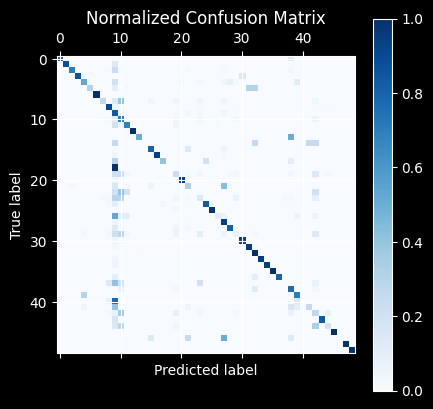

In [7]:
y_pred   = cross_val_predict(classifier, transactions_train, y_train, cv=5)    # uses stratified k-fold by default
conf_mat = confusion_matrix(y_train, y_pred)
total_per_category  = conf_mat.sum(axis=1)
conf_mat_normalized = conf_mat.astype('float') / total_per_category[:, np.newaxis]

print(f'Mean accuracy: {np.mean(y_pred == y_train)*100:.2f} %')

plt.matshow(conf_mat_normalized, cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.grid()
plt.show()

save classifier

In [ ]:
dump(classifier, cfg['categorizer file'] + '.joblib')

final test

In [9]:
y_test = transactions_test[clm['category']]
y_test_pred = classifier.predict(transactions_test)

print(f'Mean accuracy: {np.mean(y_test_pred == y_test)*100:.2f} %')

Mean accuracy: 78.51 %
